# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two approaches to DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [0]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
!unzip swda

In [0]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)


In [55]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [56]:
reduced_df = result[['act_tag','text']]
reduced_df

act_tag                                               text
0           qw            {D So, } what kind of music you into? /
1           sd  {D Well, } I have a, {F uh, } pretty wide tast...
2           sd  In fact, it's easier for me to say, {F uh, } t...
3           aa  <Laughter> The opera, {D yeah, } it's right on...
4           sd                               I like classical,  /
...        ...                                                ...
223601      fc                                           Okay,  /
223602      fc                            {D well, } thank you. /
223603      fc             {C But } it was good to talk to you. /
223604      fc                                       You, too,  /
223605      fc                                         bye-bye. /

[223606 rows x 2 columns]

Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [0]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
#Bert labels encoding
tags_y = np.argmax(tags_encoding, axis=1)

In [0]:
#for Bert model
from sklearn.model_selection import train_test_split
#tags_y = reduced_df['act_tag'].copy()
Sent_Bert = reduced_df['text'].copy()
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(Sent_Bert, tags_y)
#X_train_bert, y_test_bert



In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [0]:
# Max length of 137
MAX_LENGTH = len(max(sentences, key=len))

In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
MAX_LENGTH = 137

In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

In [0]:
#Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [0]:


train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


# Model 1 - 

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [0]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 
#print(VOCAB_SIZE,HIDDEN_SIZE)

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network
Input_size=VOCAB_SIZE+1
model = Sequential()
model.add(Embedding(input_dim=Input_size, output_dim=EMBED_SIZE,name='Embedding',input_length=MAX_LENGTH))

model.add(Bidirectional(LSTM(43,return_sequences=True),name = 'Bidirectional1'))
model.add(Bidirectional(LSTM(43,return_sequences=False),name = 'Bidirectional2'))
model.add(Dense(HIDDEN_SIZE,name = 'Dense'))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 137, 100)          4373200   
_________________________________________________________________
Bidirectional1 (Bidirectiona (None, 137, 86)           49536     
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 86)                44720     
_________________________________________________________________
Dense (Dense)                (None, 303)               26361     
_________________________________________________________________
activation_1 (Activation)    (None, 303)               0         
Total params: 4,493,817
Trainable params: 4,493,817
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Train the model - using validation 
model.fit(train_input,
                     train_labels,
                     epochs=3,
                     batch_size=100,
                     validation_data=(val_input, val_labels),verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/3
140000/140000 [==============================] - 846s 6ms/step - loss: 1.4080 - accuracy: 0.6000 - val_loss: 1.1267 - val_accuracy: 0.6648
Epoch 2/3
140000/140000 [==============================] - 841s 6ms/step - loss: 1.0046 - accuracy: 0.7022 - val_loss: 0.9894 - val_accuracy: 0.6948
Epoch 3/3
140000/140000 [==============================] - 845s 6ms/step - loss: 0.8501 - accuracy: 0.7443 - val_loss: 0.9732 - val_accuracy: 0.7020


In [23]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 65s 1ms/step


In [24]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 70.71661353111267


## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [25]:
# Generate predictions for the test data
from sklearn.metrics import accuracy_score
test_predictions = model.predict_classes(test_sentences_X, batch_size = 100)
print()

In [26]:
# Build the confusion matrix off these predictions

rounded_labels = np.argmax(y_test, axis=1)

print("Confusion matrix : \n",sklearn.metrics.confusion_matrix(rounded_labels,test_predictions))
cm=sklearn.metrics.confusion_matrix(rounded_labels,test_predictions)


Confusion matrix : 
 [[3019   67    1 ...    0    0    0]
 [  96 3404    1 ...    0    0    0]
 [  10    4   34 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   6    2    0 ...    0    3    0]
 [   2    1    0 ...    0    0    0]]


In [0]:
# Decoding dictionary
decoding_dic= {}

for i in one_hot_encoding_dic.columns:
 decoding_dic[np.argmax(one_hot_encoding_dic[i])] = i

Classes_names = []
for i in range(len(decoding_dic.items())):
  Classes_names.append(decoding_dic[i])



In [27]:

print("classification_report: \n",sklearn.metrics.classification_report(rounded_labels,test_predictions,target_names = Classes_names))

#function for ploting confusion matrix
def Cal_Accuracy_Minority(class_name,ConfusionMatrix):

    # Finding position of class in confusion Matrix
    Position = np.argmax(one_hot_encoding_dic[class_name])
    print('Position:',Position)

    # Finding True positive
    TP_minority = ConfusionMatrix[Position][Position]

    # Total instances

    instances = 0 
    for i in range(len(ConfusionMatrix)):

        instances += ConfusionMatrix[Position][i]

    print('Instance :', instances)

    # Accuracy

    Accuracy_min = TP_minority/instances

    return Accuracy_min

# Calculate Accuracies for "br" and "bf" for imbalanced data
accuracy_br = Cal_Accuracy_Minority('br',cm)
accuracy_bf = Cal_Accuracy_Minority('bf',cm)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)

NameError: ignored

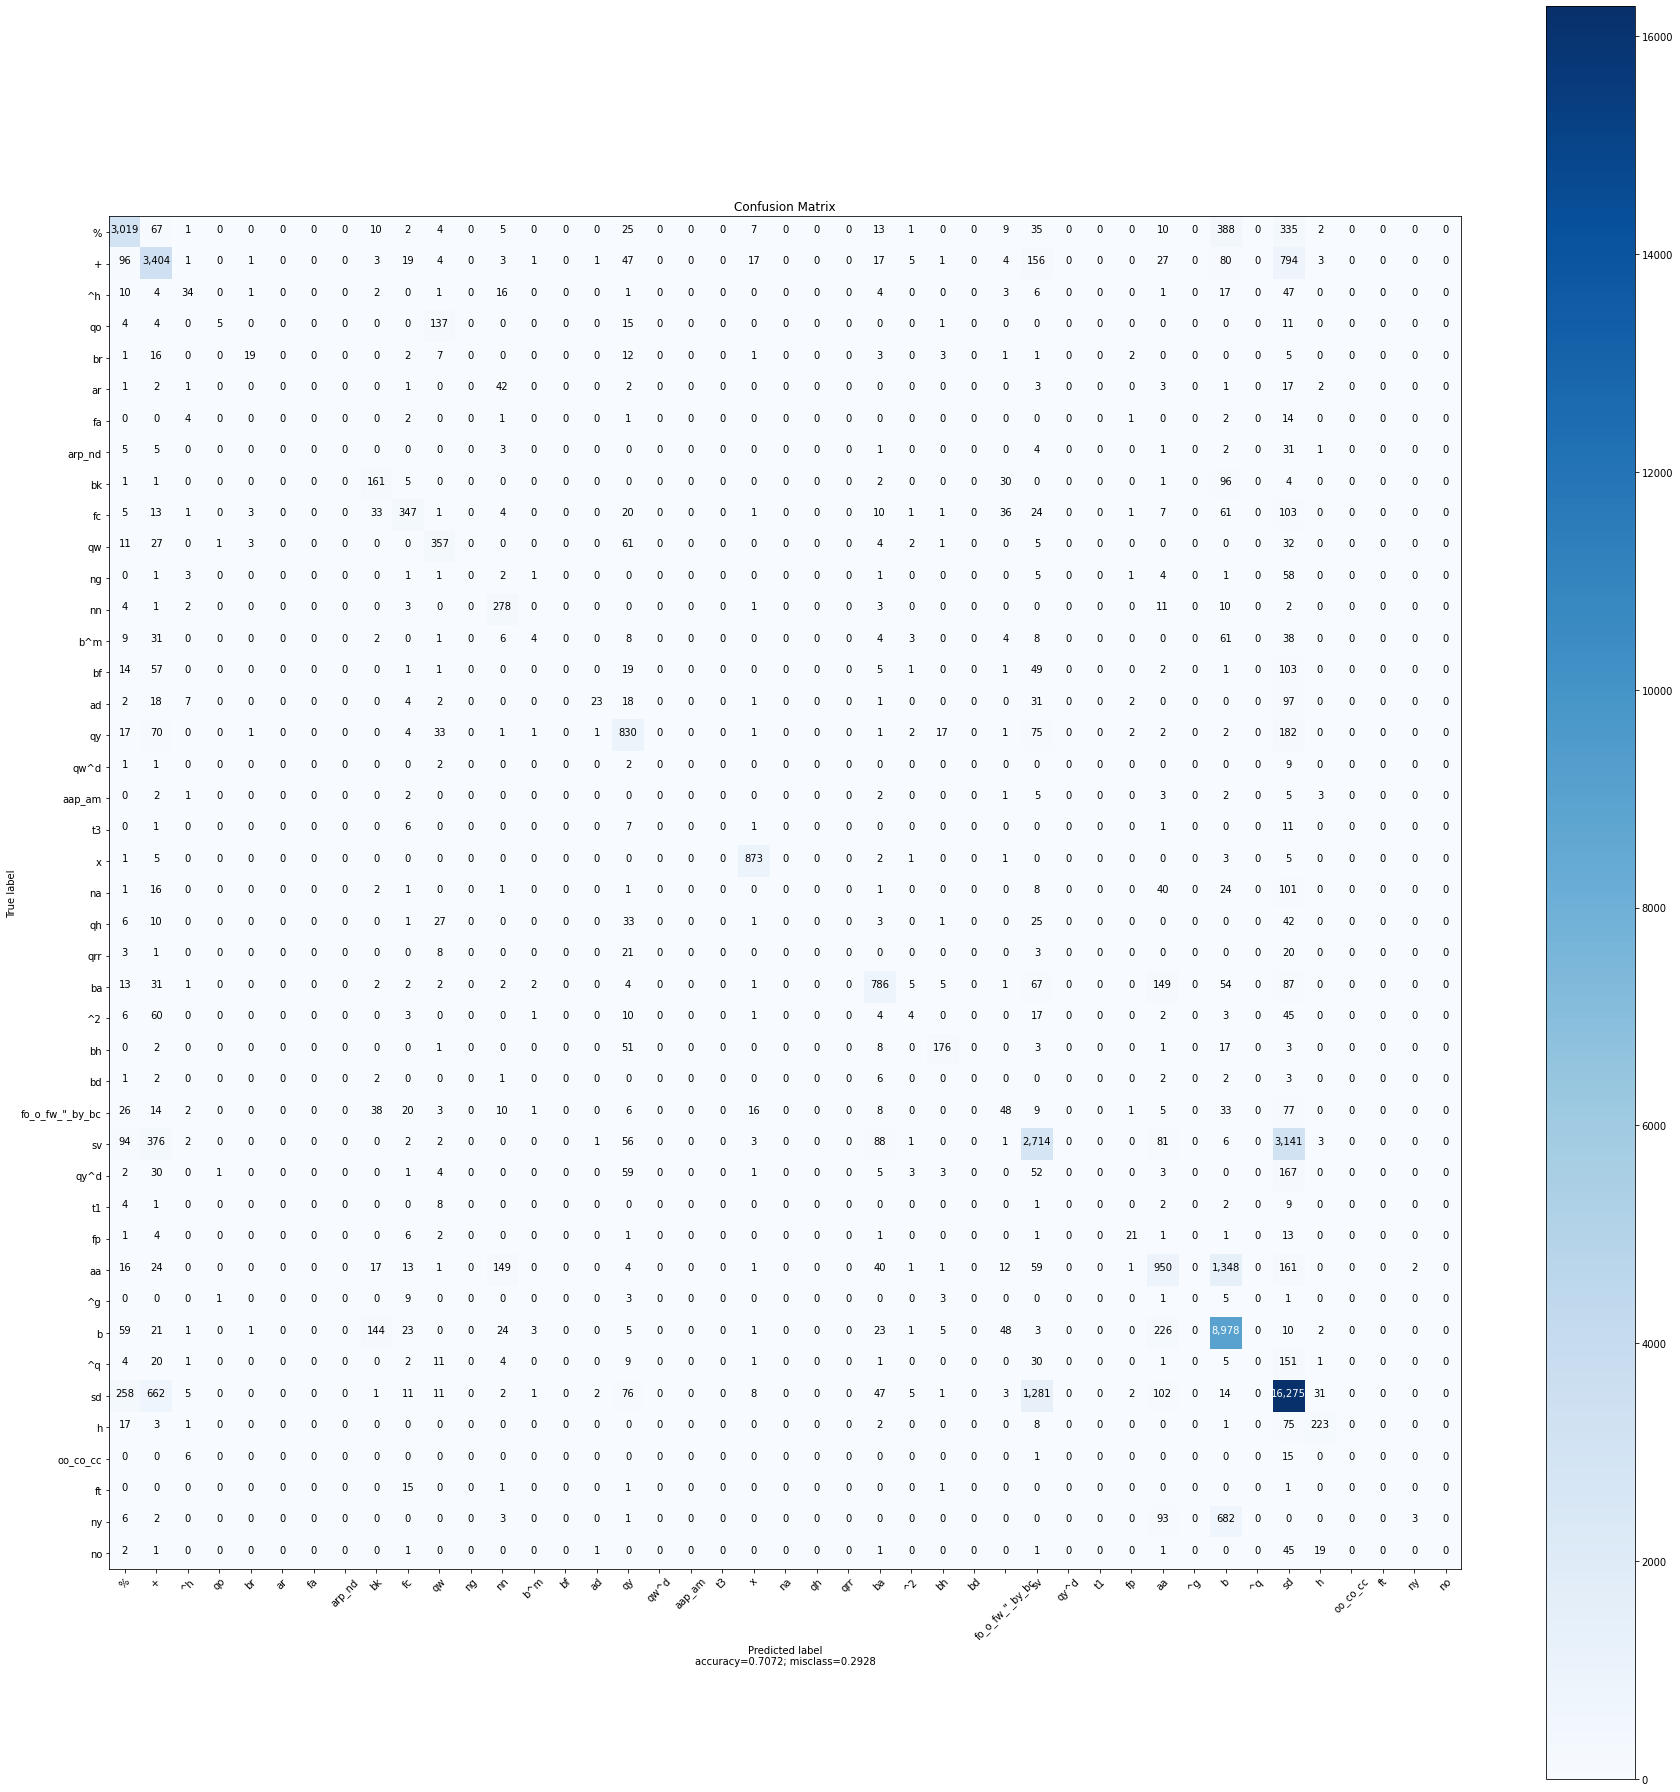

In [36]:
#function to plot confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
#to find the error of misclassified data confusion matrix of imbalanced data is ploted
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")


Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

## Define & Train the model

In [38]:
# Re-built the model for the balanced training
model_balanced = Sequential()
model_balanced.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBED_SIZE,name='Embedding',input_length=MAX_LENGTH))

model_balanced.add(Bidirectional(LSTM(43,return_sequences=True),name = 'Bidirectional1'))
model_balanced.add(Bidirectional(LSTM(43,return_sequences=False),name = 'Bidirectional2'))
model_balanced.add(Dense(HIDDEN_SIZE,name = 'Dense'))
model_balanced.add(Activation('softmax'))
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model_balanced.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 137, 100)          4373200   
_________________________________________________________________
Bidirectional1 (Bidirectiona (None, 137, 86)           49536     
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 86)                44720     
_________________________________________________________________
Dense (Dense)                (None, 43)                3741      
_________________________________________________________________
activation_2 (Activation)    (None, 43)                0         
Total params: 4,471,197
Trainable params: 4,471,197
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the balanced network -  takes  time to achieve good accuracy
model_balanced.fit(train_input,
                     train_labels,
                     epochs=3,
                     batch_size=100,
                     class_weight = d_class_weights,
                     validation_data=(val_input, val_labels),verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/3
140000/140000 [==============================] - 854s 6ms/step - loss: 2.9865 - accuracy: 0.2549 - val_loss: 2.3814 - val_accuracy: 0.3338
Epoch 2/3
140000/140000 [==============================] - 861s 6ms/step - loss: 2.1174 - accuracy: 0.3810 - val_loss: 2.0929 - val_accuracy: 0.4300
Epoch 3/3
140000/140000 [==============================] - 850s 6ms/step - loss: 1.6885 - accuracy: 0.4350 - val_loss: 1.9103 - val_accuracy: 0.4543


## Test the model

In [40]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 65s 1ms/step


In [41]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 45.33827006816864


In [0]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Position: 4
Instance : 73
Position: 14
Instance : 254
accuracy of br is : 0.4794520547945205
accuracy of bf is : 0.11023622047244094
classification_report: 
                  precision    recall  f1-score   support

              %       0.63      0.82      0.71      3933
              +       0.72      0.48      0.58      4684
             ^h       0.14      0.50      0.22       147
             qo       0.53      0.66      0.58       177
             br       0.22      0.48      0.31        73
             ar       0.02      0.01      0.02        75
             fa       0.10      0.76      0.18        25
         arp_nd       0.01      0.21      0.02        53
             bk       0.22      0.79      0.34       301
             fc       0.78      0.44      0.57       672
             qw       0.70      0.53      0.60       504
             ng       0.01      0.32      0.03        79
             nn       0.46      0.92      0.61       315
            b^m       0.05      0.13      0

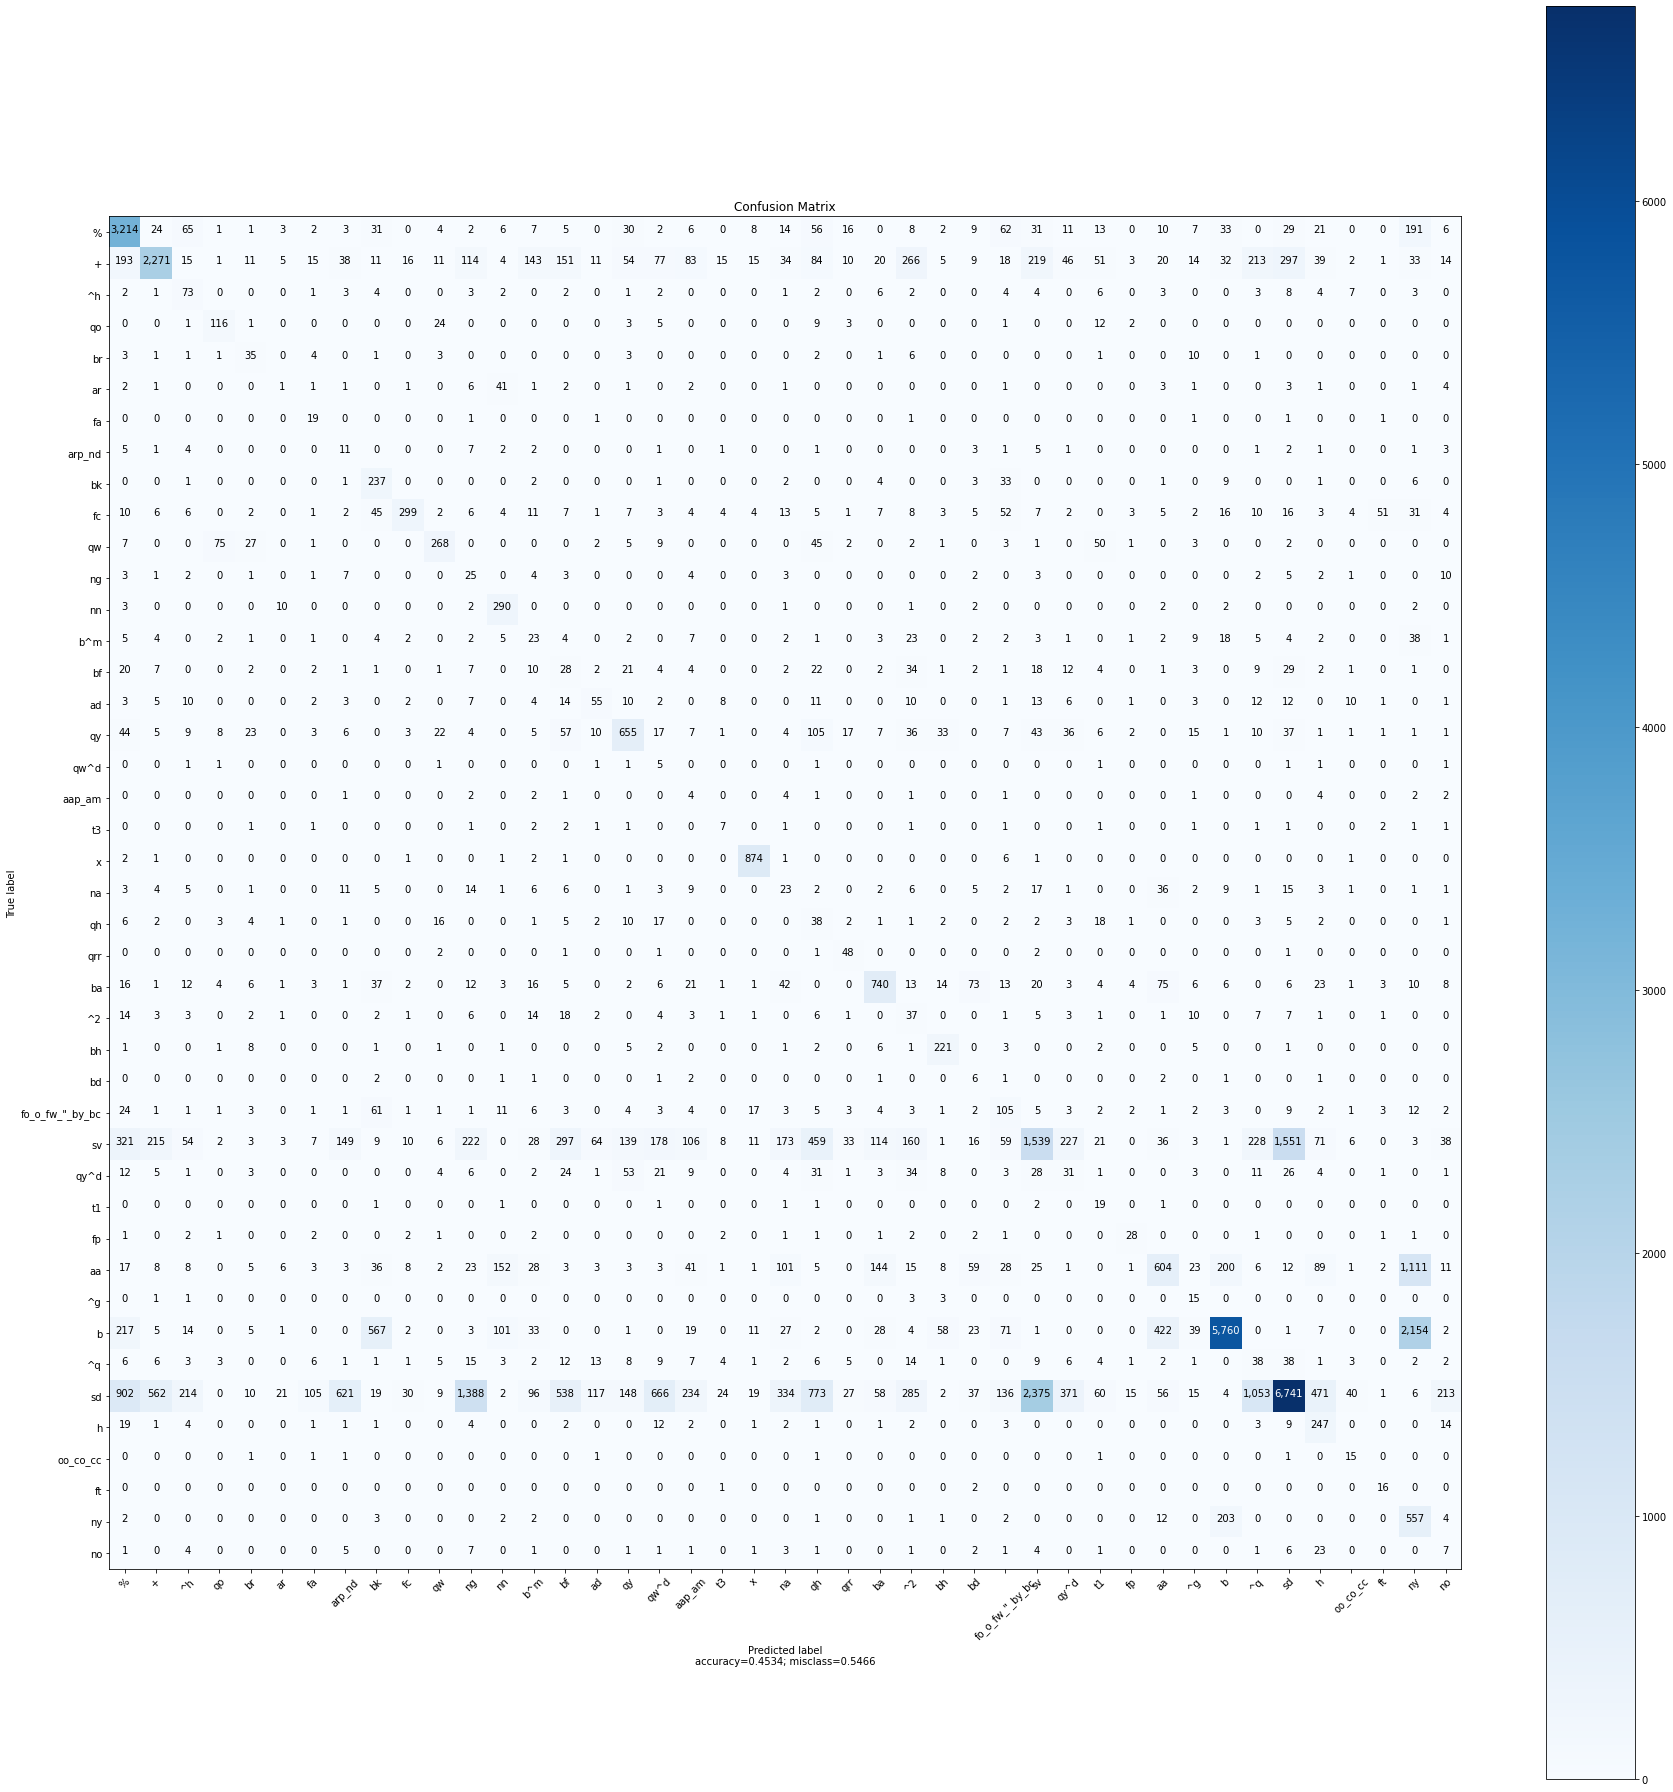

In [43]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

# Calculate Accuracies for "br" and "bf" after balancing the data
accuracy_br = Cal_Accuracy_Minority('br',matrix_balanced)
accuracy_bf = Cal_Accuracy_Minority('bf',matrix_balanced)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)
print("classification_report: \n",sklearn.metrics.classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1),target_names = Classes_names))
plot_confusion_matrix(matrix_balanced, 
                      normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")



### Accuracies



### Explanation


### Other ways to handle imbalanced classes


- 

- 

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [0]:
from keras.layers import Input
from keras.layers import Reshape
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D#concat
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization
from keras import Model 
filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 
#Input=(shape=(MAX_LENGTH, ), dtype='int32')
# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
added = concatenate([maxpool_0, maxpool_1 ,maxpool_2])
# flatten concatenated tensors
flatten=Flatten()(added)
# dense layer (dense_1)
dense_1=Dense(10, activation='softmax')(flatten)
# dropout_1
dropout_1 = Dropout(drop)(dense_1)

## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.

In [0]:
# BLSTM model

Bidirectional_1=Bidirectional(LSTM(HIDDEN_SIZE,return_sequences=True))(embedding)
# Bidirectional 2
Bidirectional_2=Bidirectional(LSTM(HIDDEN_SIZE,return_sequences=False))(Bidirectional_1)
# Dense layer (dense_2)
dense_2=Dense(10, activation='softmax')(Bidirectional_2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer

In [0]:
# concatenate 2 final layers
a=concatenate([dropout_1,dropout_2])

# output
output = Model(inputs=inputs, outputs=a)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
# Train the model - using validation 
model.fit(train_input,
                     train_labels,
                     epochs=3,
                     batch_size=100,
                     validation_data=(val_input, val_labels),verbose=1)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 140000 samples, validate on 27704 samples
Epoch 1/3
140000/140000 [==============================] - 945s 7ms/step - loss: 0.7536 - accuracy: 0.7736 - val_loss: 0.9814 - val_accuracy: 0.7016
Epoch 2/3
140000/140000 [==============================] - 950s 7ms/step - loss: 0.7268 - accuracy: 0.7802 - val_loss: 0.9839 - val_accuracy: 0.7036
Epoch 3/3
140000/140000 [==============================] - 934s 7ms/step - loss: 0.7064 - accuracy: 0.7857 - val_loss: 0.9860 - val_accuracy: 0.7001


In [48]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 64s 1ms/step


In [49]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 70.5717146396637


In [0]:
label_pred = model.predict(test_sentences_X, batch_size=100)

Position: 4
Instance : 73
Position: 14
Instance : 254
accuracy of br is : 0.5342465753424658
accuracy of bf is : 0.015748031496062992
classification_report: 
                  precision    recall  f1-score   support

              %       0.82      0.78      0.80      3933
              +       0.71      0.72      0.71      4684
             ^h       0.51      0.35      0.41       147
             qo       0.48      0.54      0.51       177
             br       0.38      0.53      0.44        73
             ar       0.00      0.00      0.00        75
             fa       0.00      0.00      0.00        25
         arp_nd       0.00      0.00      0.00        53
             bk       0.53      0.29      0.37       301
             fc       0.63      0.54      0.58       672
             qw       0.68      0.57      0.62       504
             ng       0.00      0.00      0.00        79
             nn       0.52      0.90      0.66       315
            b^m       0.11      0.10      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


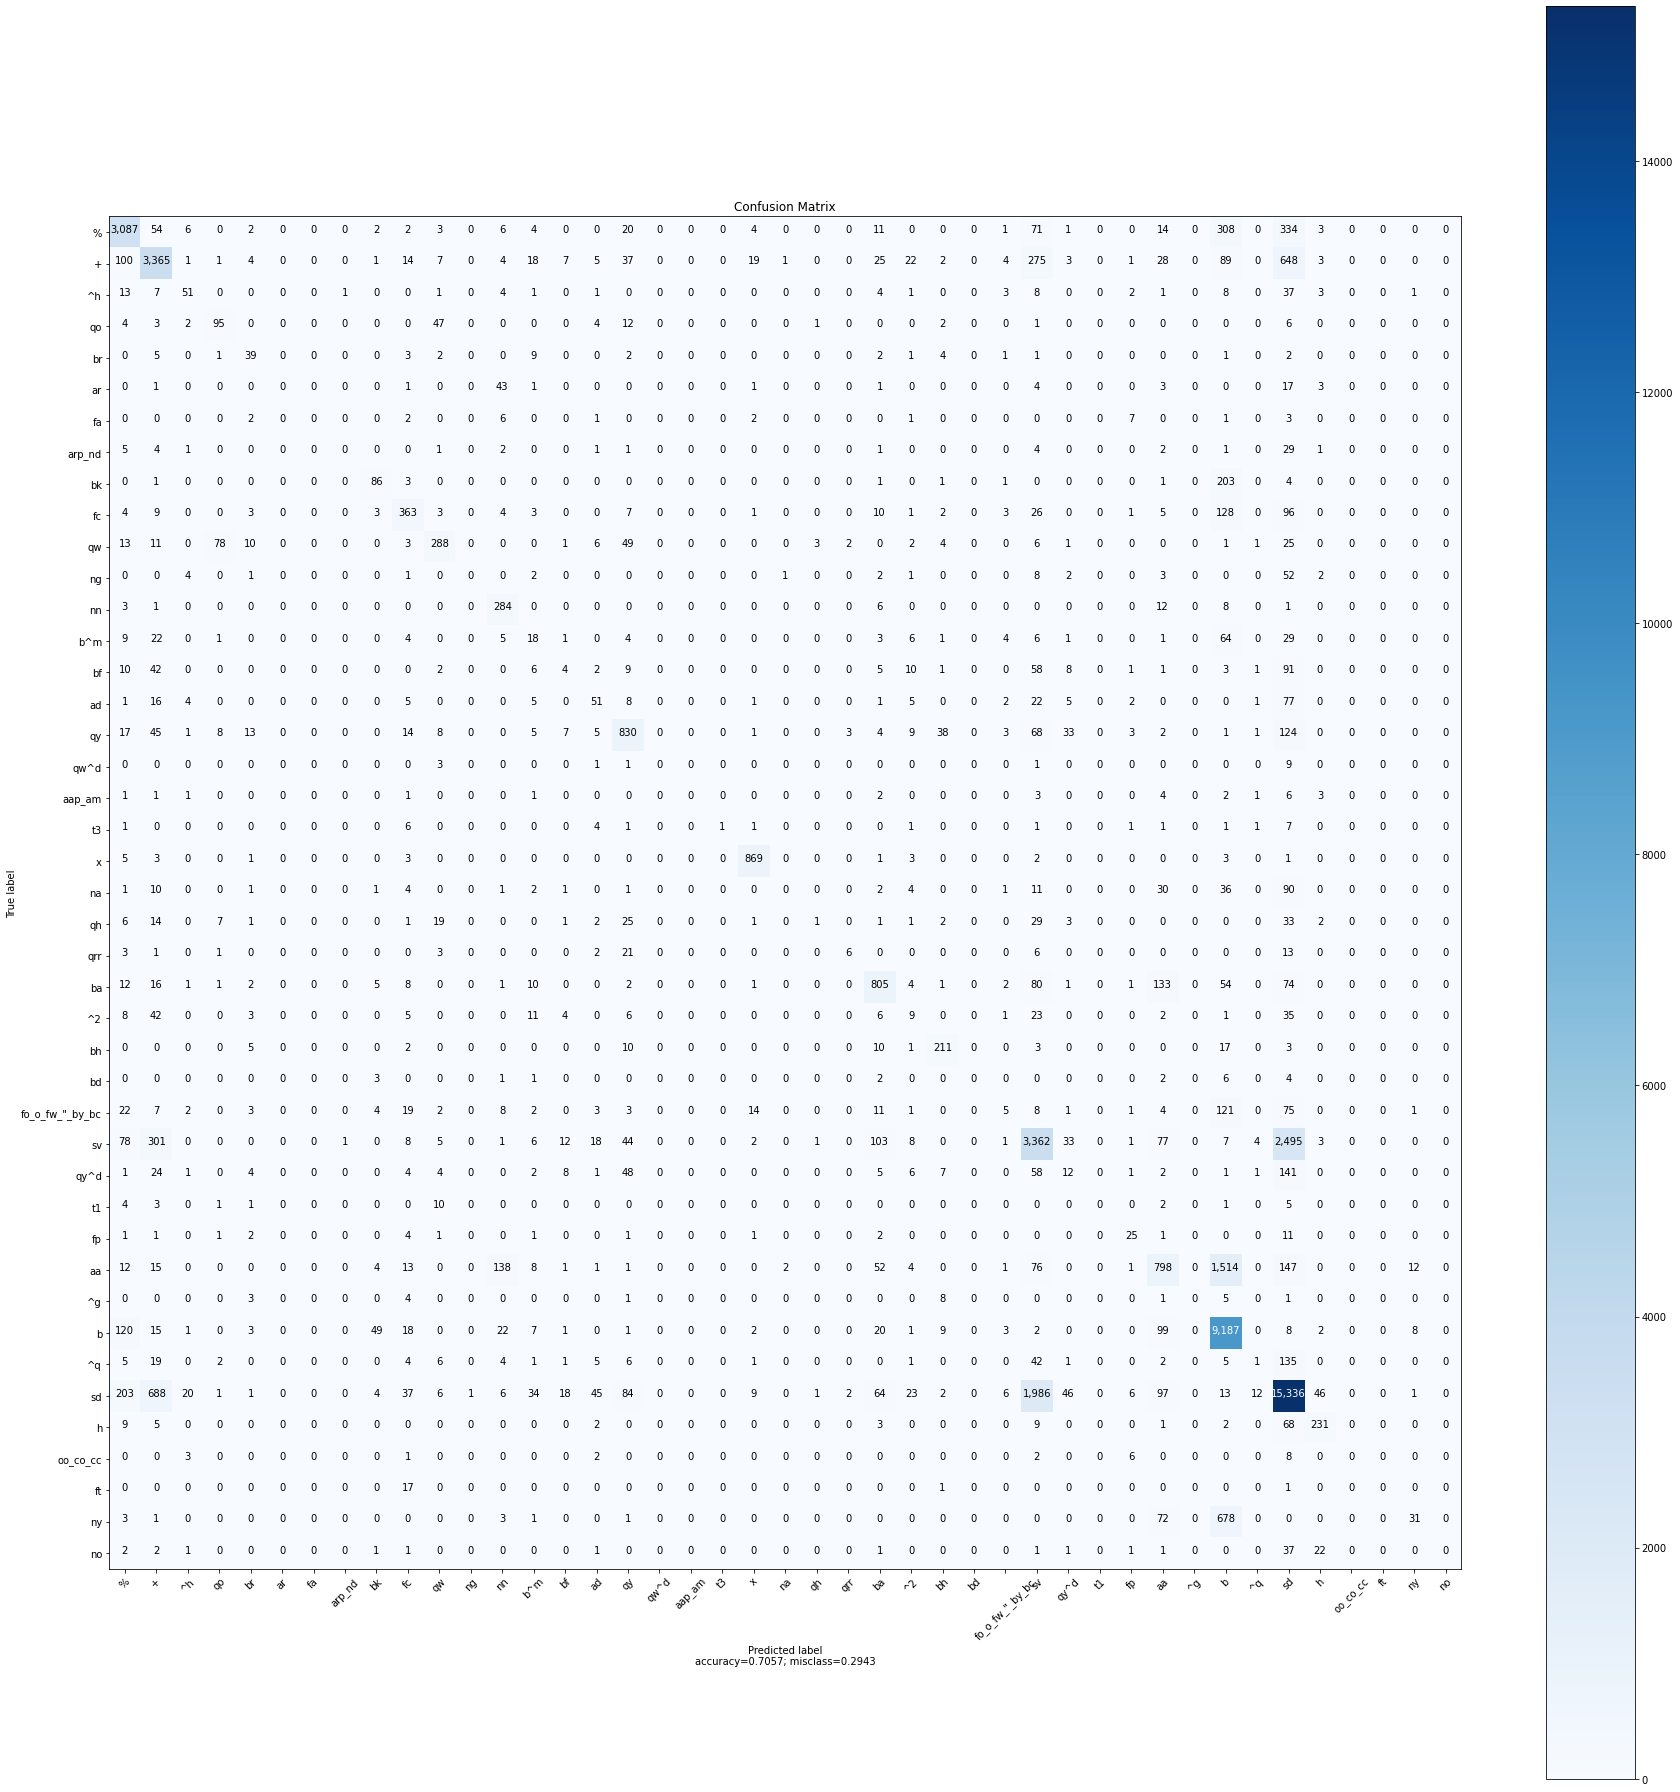

In [51]:
hierarchical_matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

# Calculate Accuracies for "br" and "bf" for hierarchical model
accuracy_br = Cal_Accuracy_Minority('br',hierarchical_matrix)
accuracy_bf = Cal_Accuracy_Minority('bf',hierarchical_matrix)
print('accuracy of br is :',accuracy_br)
print('accuracy of bf is :',accuracy_bf)
print("classification_report: \n",sklearn.metrics.classification_report(y_test.argmax(axis=1), label_pred.argmax(axis=1),target_names = Classes_names))
plot_confusion_matrix(hierarchical_matrix, 
                      normalize    = False,
                      target_names = Classes_names,
                      title        = "Confusion Matrix")

Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




### Minority Classes



# Advanced:  Bert-Based Model for Dialogue Act Tagging

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.

In [0]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import numpy as np
from tokenization import FullTokenizer
from tqdm import tqdm_notebook
from tensorflow.keras import backend as K
#!pip install tensorflow==1.15
# Initialize session
sess = tf.compat.v1.Session()
# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
MAX_LENGTH = 137

In [72]:
class PaddingInputExample(object):
    """Fake example so the num input examples is a multiple of the batch size.
  
  """


class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():

    bert_module =  hub.Module(bert_path)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    vocab_file, do_lower_case = sess.run(
        [
            tokenization_info["vocab_file"],
            tokenization_info["do_lower_case"],
        ]
    )

    return FullTokenizer(vocab_file=vocab_file, do_lower_case=do_lower_case)

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm_notebook(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples"""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=" ".join(text), text_b=None, label=label)
        )
    return InputExamples

# Task 1
#from tokenization import BasicTokenizer

tokenizer = create_tokenizer_from_hub_module()

# Convert data to InputExample format
train_examples = convert_text_to_examples(X_train_bert, y_train_bert)
test_examples = convert_text_to_examples(X_test_bert, y_test_bert)

# Convert to features
(train_input_ids, train_input_masks, train_segment_ids, train_labels 
) = convert_examples_to_features(tokenizer, train_examples, max_seq_length=MAX_LENGTH)
(test_input_ids, test_input_masks, test_segment_ids, test_labels
) = convert_examples_to_features(tokenizer, test_examples, max_seq_length=MAX_LENGTH)

# End of Task 1
#X_train_bert, X_test_bert, y_train_bert, y_test_bert

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:76: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_path="https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_path = bert_path
        if self.pooling not in ["first", "mean"]:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_path, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        if self.pooling == "first":
            trainable_vars = [var for var in trainable_vars if not "/cls/" in var.name]
            trainable_layers = ["pooler/dense"]

        elif self.pooling == "mean":
            trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
            trainable_layers = []
        else:
            raise NameError(
                f"Undefined pooling type (must be either first or mean, but is {self.pooling}"
            )

        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        if self.pooling == "first":
            pooled = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]
        elif self.pooling == "mean":
            result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "sequence_output"
            ]

            mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)
            masked_reduce_mean = lambda x, m: tf.reduce_sum(mul_mask(x, m), axis=1) / (
                    tf.reduce_sum(m, axis=1, keepdims=True) + 1e-10)
            input_mask = tf.cast(input_mask, tf.float32)
            pooled = masked_reduce_mean(result, input_mask)
        else:
            raise NameError(f"Undefined pooling type (must be either first or mean, but is {self.pooling}")

        return pooled

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [0]:
def build_model(max_seq_length): 
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_output = BertLayer(n_fine_tune_layers=3, pooling="first")(bert_inputs)
    dense = tf.keras.layers.Dense(256, activation='relu')(bert_output)
    pred = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# End of Task 2
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)



In [0]:
#print(train_labels,test_labels)
# Train the model - using validation 
model = build_model(MAX_LENGTH)
initialize_vars(sess)
model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([test_input_ids, test_input_masks, test_segment_ids], test_labels),
    epochs=1,
    batch_size=32
)